In [1]:
import requests
import json
import re
import os
import pandas as pd 
import numpy as np
import random
import warnings

from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker, Classifier
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib
import pickle

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Set input file directory
ip_file_dir = "../Data/Target Data/"

# Get grocery product hierarchy information
group10 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group10_header.csv'),
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products.csv'))

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

In [3]:
group10.head(2)

,tcin,item_state,title,update_ts,brand_classification,brand_group,brand_id,brand,class_id,class_name,department_id,department_name,division_id,division_name,estore_item_status_c,estore_item_status,group_id,group_name,has_image,intended_selling_channels,is_published_flag,is_sellable,is_size_mix,is_standard_item,is_targetcom_ready,is_weight_required,item_kind,item_type_category_type,item_type_name,item_type,launch_date_time,manufacturer_brand,net_content_quantity_unit_of_measure,net_content_quantity_value,organic_c,package_depth,package_dimension_unit_of_measure,package_height,package_weight_unit_of_measure,package_weight,package_width,product_subtype_name,product_subtype,product_type_name,product_type,record_source_c,reference_color,reference_pattern_id,reference_size,relationship_kit_type,relationship_type_c,relationship_type,short_desc,size_chart,size_group_name,street_d,style_id,style_name,sub_group_id,sub_group_name,subclass_id,subclass_name,temperature_sensitivity_c,units_per_package,upc,variation_color,variation_other_label,variation_other,variation_size,variation_theme,price,rating,n_reviews,highlights,specifications,description,serving_info,nutrition_info,ingredients,allergens,images,image,title_modified
0,12920260,READY_FOR_LAUNCH,Blue Diamond Almonds Wasabi & Soy Sauce - 6oz,2021-08-12 22:12:38,National-National,National,801,Blue Diamond Almonds,8,DC SALTY SNACKS,71,SNACKS,19,SNACKS/CANDY,A,Active,10,FOOD/BEVERAGE,True,Sold in Store,True,True,\N,\N,\N,\N,\N,\N,"Nuts, Seeds and Legumes",44601096,2010-08-19 07:00:00,\N,OUNCE,6,Not organic,3.54,INCH,2.72,POUND,0.46,3.38,SNACK,109516,GROCERY,109420,Corona,\N,\N,\N,\N,SA,Stand Alone,BLUE DIAMOND BLUE DIAMOND ALMONDS,\N,\N,\N,071-08-05-ABT66,B DIA ALMND S WSBI,24,SNACKS/BEV/CANDY,071-08-05,NUTS,\N,1,\N,\N,\N,\N,\N,\N,4.29,4.8,33.0,[Contains 6 - 6 ounce tins of Blue Diamond Bol...,"[Origin: Made in the USA or Imported, Package ...","When we first heard the idea, we were a little...","[Serving Size: 1 oz, Serving Per Container: 6]","[[Total Fat, 15g], [Saturated Fat, 1g], [Trans...","almonds, wasabi soy sauce seasoning (sugar, mo...",Allergens & Warnings:MAY CONTAIN OTHER TREE NUTS.,[https://target.scene7.com/is/image/Target/GUE...,https://target.scene7.com/is/image/Target/GUES...,blue diamond almonds wasabi soy sauce
1,12921061,READY_FOR_LAUNCH,Thomas' Everything Bagel Thins - 13oz/8ct,2021-08-29 07:08:41,National-National,National,7312,Thomas,1,BREAD,261,BREAD/BAKING,50,DRY GROCERY,A,Active,10,FOOD/BEVERAGE,True,Sold in Store,True,True,\N,\N,\N,\N,\N,\N,Bagels,74015137,2010-08-19 07:00:00,\N,OUNCE,13,Not organic,5.50,INCH,3.16,POUND,0.81,9.00,BREAD AND DESSERTS,120906,GROCERY,109420,Corona,\N,\N,\N,\N,SA,Stand Alone,THOMAS EVERYTHING THIN BAGELS,\N,\N,\N,261-01-02-AAD75,THOMAS BAGELS,25,DRY GROCERY,261-01-02,BREAKFAST,\N,1,\N,\N,\N,\N,\N,\N,3.89,4.6,32.0,[Contains 8 Thomas' Everything Bagel Thins per...,"[Origin: Made in the USA or Imported, TCIN: 12...",Everything you’re craving in a thinner bagel. ...,"[Serving Size: 46 g, Serving Per Container: 8]","[[Total Fat, 1g], [Saturated Fat, 0g], [Trans ...","enriched wheat flour [flour, malted barley flo...","Allergens & Warnings:CONTAINS WHEAT, SOY, SESA...",[https://target.scene7.com/is/image/Target/GUE...,https://target.scene7.com/is/image/Target/GUES...,thomas everything bagel thins ct


In [4]:
# lm = SentenceTransformer('models/triplet-models/class_name_v2')
# clf = CrossEncoder('models/nli-classification-class_name')
lm = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [5]:
# Get list of preprocessed product titles
product_ids = group10['tcin'].values

In [7]:
group10['class_name'] = np.where(pd.isnull(group10['class_name']), '', group10['class_name'])
group10['subclass_name'] = np.where(pd.isnull(group10['subclass_name']), '', group10['subclass_name'])
# group10['short_desc'] = np.where(pd.isnull(group10['short_desc']), '', group10['short_desc'])
group10['style_name'] = np.where(pd.isnull(group10['style_name']), '', group10['style_name'])
group10['item_type_name'] = np.where(pd.isnull(group10['item_type_name']), '', group10['item_type_name'])
# group10['highlights'] = np.where(pd.isnull(group10['highlights']), '', group10['highlights'])
# group10['description'] = np.where(pd.isnull(group10['description']), '', group10['description'])

product_sentences = list(group10['class_name'].str.cat(group10[['subclass_name', 
                                                                'item_type_name', 
                                                                'style_name', 'title'
                                                        ]], 
                                             sep= ' ').str.lower().values)


In [9]:
# Compute embeddings
pool = lm.start_multi_process_pool(target_devices=['cpu']*8)
emb = lm.encode_multi_process(product_sentences, pool)
# Store sentences & embeddings on disc
with open('data/hier_embeddings3.pkl', "wb") as fOut:
    pickle.dump({'ids': product_ids,
                 'sentences': product_sentences, 
                 'embeddings': emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
#Load sentences & embeddings from disc
with open('data/hier_embeddings3.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']

In [11]:
tr = TransformerRanker(model=lm, product_ids=product_ids, max_rank=6)
tr.load_embeddings(stored_embeddings)
pm = Mapper(group10)
dp = DisplayProducts(ranker=tr, mapper=pm)

sugar
[14627921, 47095873, 78717720, 13379070, 14778267, 16772711, 77644482, 54436324, 13335745, 77645203]


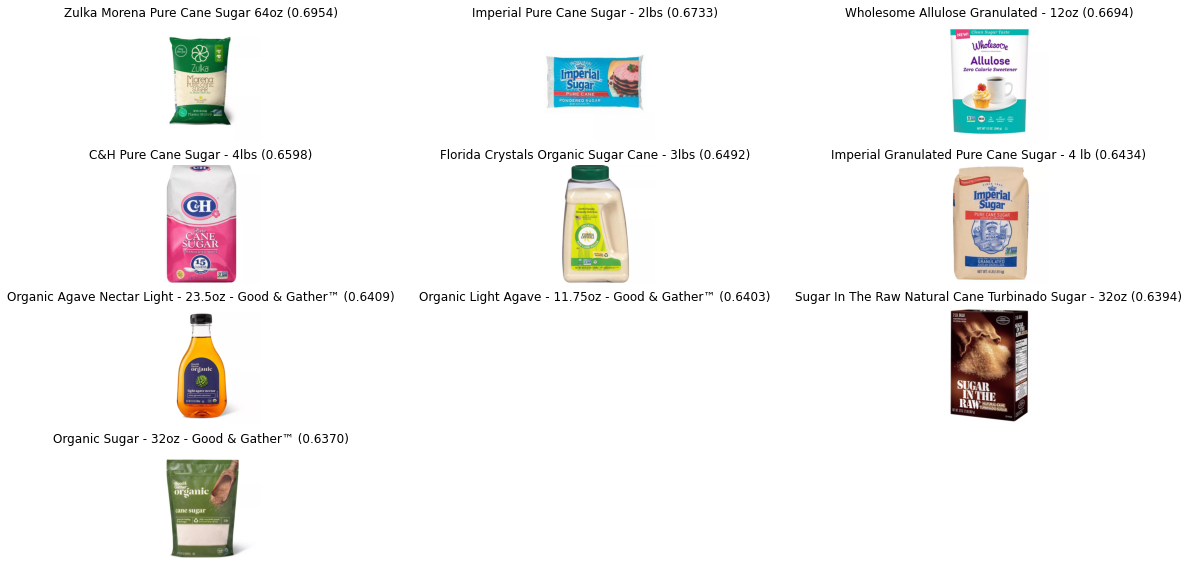

In [12]:
dp.display_products_ingredient('sugar', 10)

In [13]:
df = pd.DataFrame()
df['ids'] = stored_data['ids']
df['sentences'] = stored_data['sentences']
print(df[df['ids'] == 82427725]['sentences'].values)


['dsd base water dsd store option water dsd store option evian natural spring water - 33.8 fl oz bottle']


In [14]:
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
cross_encoder_name = "cross-encoder/ms-marco-MiniLM-L-4-v2"
classifier_name = 'model/nli-classification-class_name'
k=3

In [15]:
base_clf = CrossEncoder('models/nli-classification-class_name')
clf = Classifier(clf, pm, 'class_name')

In [16]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

bi_encoder = SentenceTransformer(bi_encoder_name)

# Get list of preprocessed product titles
product_titles = group10['title'].str.lower().values

l1_ranker = TransformerRanker(model=bi_encoder, 
                              product_ids=group10['tcin'], 
                              max_rank=3,
                              clf=clf)
with open('data/hier_embeddings3.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']
df = pd.DataFrame()
df['id'] = stored_data['ids']
df['sentence'] = stored_data['sentences']
l1_ranker.load_embeddings(stored_embeddings)

cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)
l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map('data/hier_embeddings3.pkl'),
                                cross_rank=k,
                                bi_rank=30)

pm = Mapper(group10)
dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [17]:
ingredient = 'water'
l1_ranker.rank_products_ingredient(ingredient, 3)

Filtered water for class_name: DC BASE WATER


[13052275, 14150940, 14127478]

In [18]:
ingredient = 'black pepper'
tcin_list = l1_ranker.rank_products_ingredient(ingredient, 100)
tcin_list = clf.filter_by_class(ingredient, tcin_list)

Filtered black pepper for class_name: MEXICAN/BADIA/GOYA
Filtered black pepper for class_name: MEXICAN/BADIA/GOYA


In [19]:
# dp.display_products_ingredient_tcins(tcin_list[0:10])

Filtered salt for class_name: SPICES
salt
[78140861, 47094599, 13171236, 13171237, 78140513, 13170337, 13406684, 13170448, 13170338, 13012161]


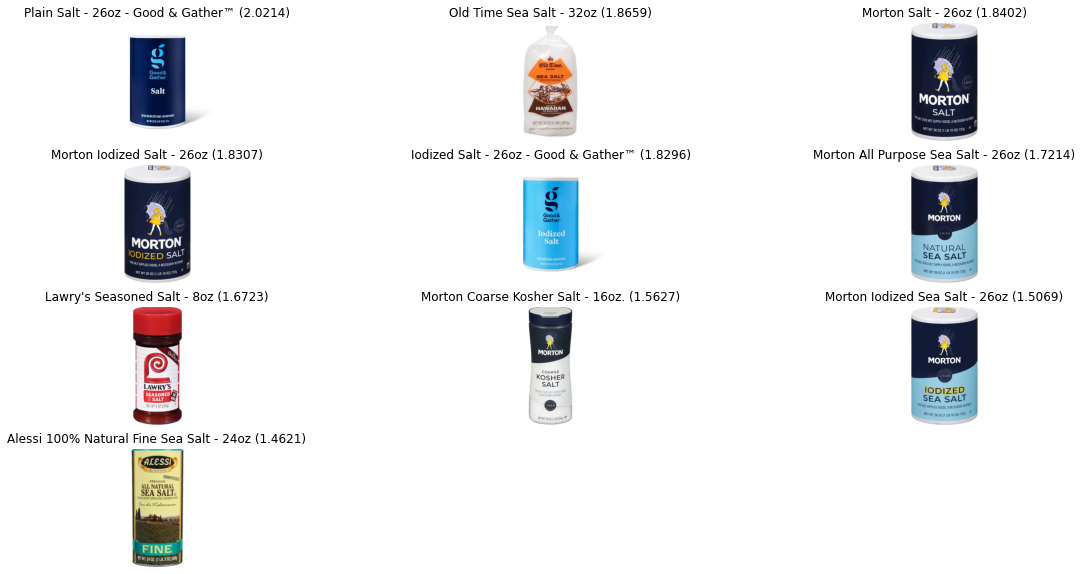

In [23]:
dp.display_products_ingredient('salt', 10)